In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import uproot
import ROOT
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.integrate as intg 
from scipy.stats import norm
from numpy.random import normal
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
import sipm.util.functions as func

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


# Change channel mapping in calibration file from liq5

In [26]:
# store_in = pd.HDFStore('data/calibration_liq5_2023-12-13.h5')
# keys = store_in.keys()
# store_out = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# for k in keys:
#     df = store_in.get(k)
#     df['channel'] = [0,5,6,3,4,1,2,7]
#     df = df.sort_values('channel')
#     df.index = df['channel'].to_numpy()
#     df['max_amp'] = [1490]*4+[1440]*4
#     store_out.put(k,df)
# store_out.close()

In [27]:
# store_new = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# df = store_new.get('98V')
# print(df)
# store_new.close()

   channel   A1min   A1max      DiCT  DiCT_err         Qavg  Qavg_err  \
0        0  182.50  614.75  0.062552  0.002565  1365.207392  2.056569   
1        1  150.00  507.50  0.078832  0.002711  1083.812145  1.634559   
2        2  166.25  517.25  0.038044  0.005497  1074.883609  1.725839   
3        3  172.75  595.25  0.063979  0.002884  1347.247295  2.212291   
4        4  137.00  491.25  0.037938  0.004298  1089.928296  2.027596   
5        5  179.25  605.00  0.064871  0.002205  1340.736508  1.602492   
6        6  179.25  595.25  0.061345  0.001571  1348.687297  1.487120   
7        7  159.75  523.75  0.041940  0.001757  1085.203042  1.247101   

         Qpeak  Qpeak_err       Qap   Qap_err  bsl_rms      fano  max_amp  
0  1312.638376   4.241427  0.037543  0.003476      2.0  1.103519     1490  
1  1060.960322   1.525312  0.019841  0.001961      2.0  1.098699     1490  
2  1054.027538   1.298818  0.019034  0.001985      2.0  1.061482     1490  
3  1293.013336   2.911347  0.039260  0

## Visualize waveforms from original binary files

/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave0.dat
10 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave1.dat
10 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave2.dat
10 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave3.dat
10 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave4.dat
10 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave5.dat
10 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-23/2024-02-23_volt_98_light_scintillation_sou

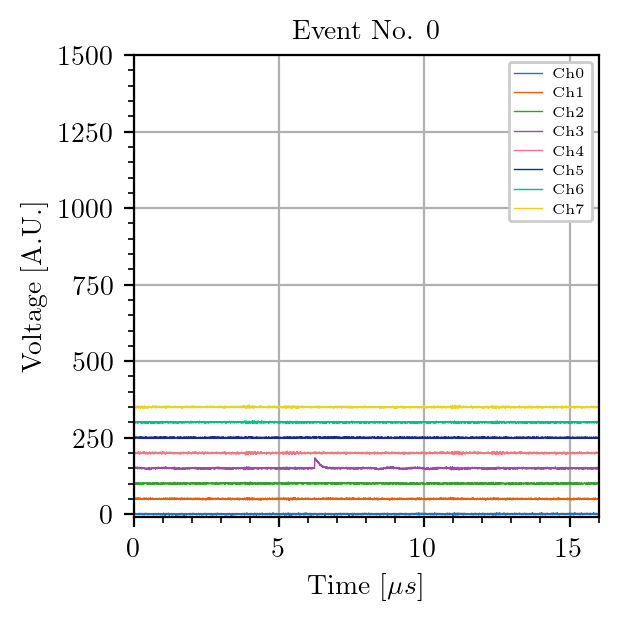

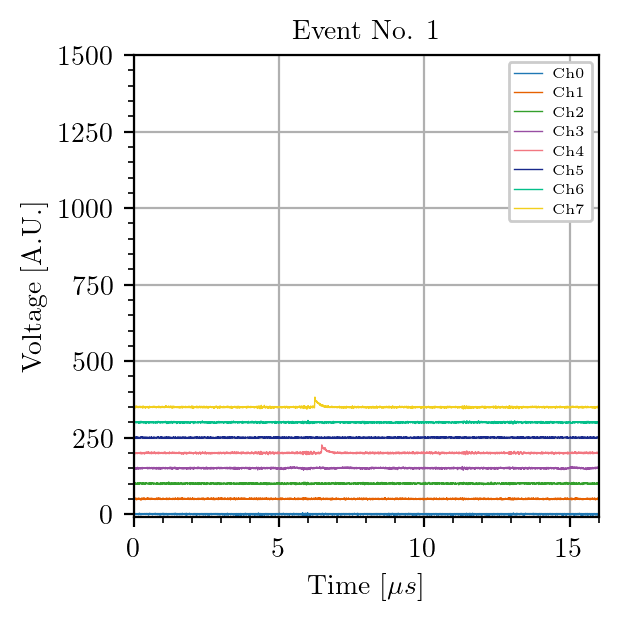

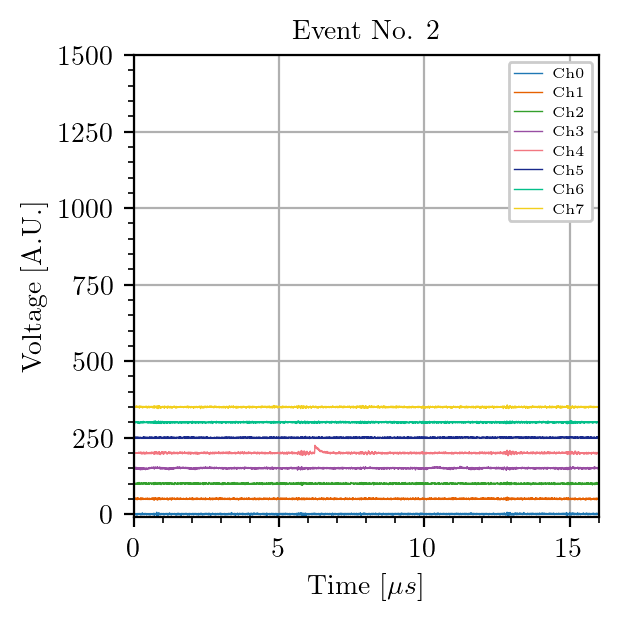

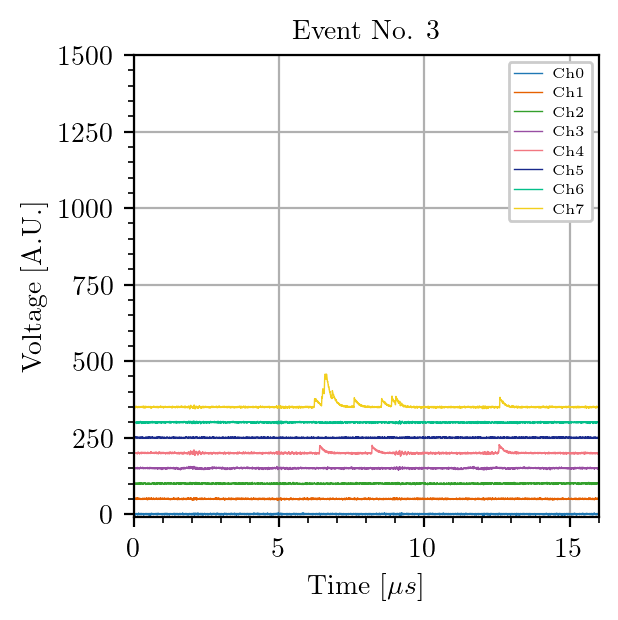

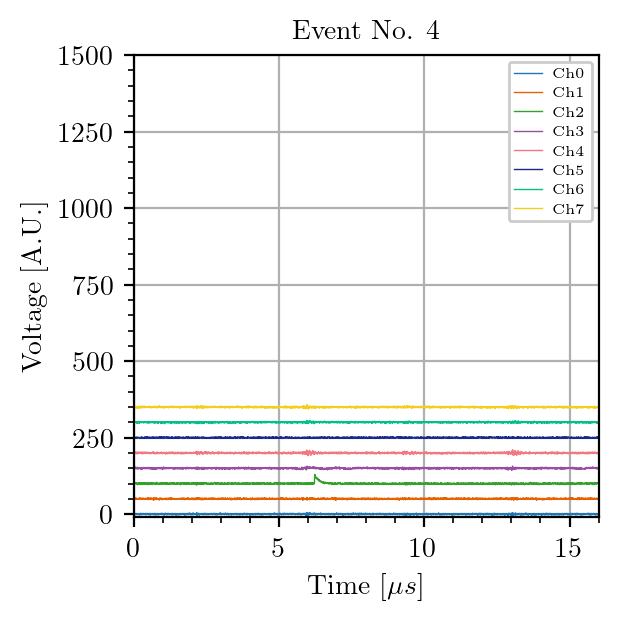

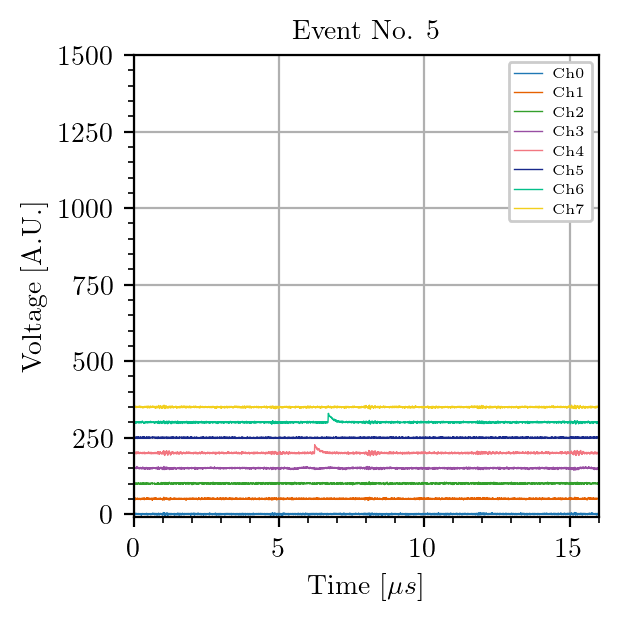

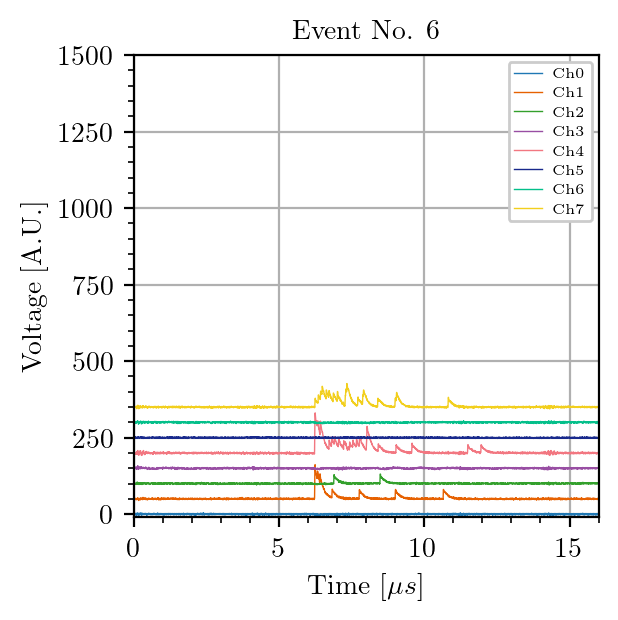

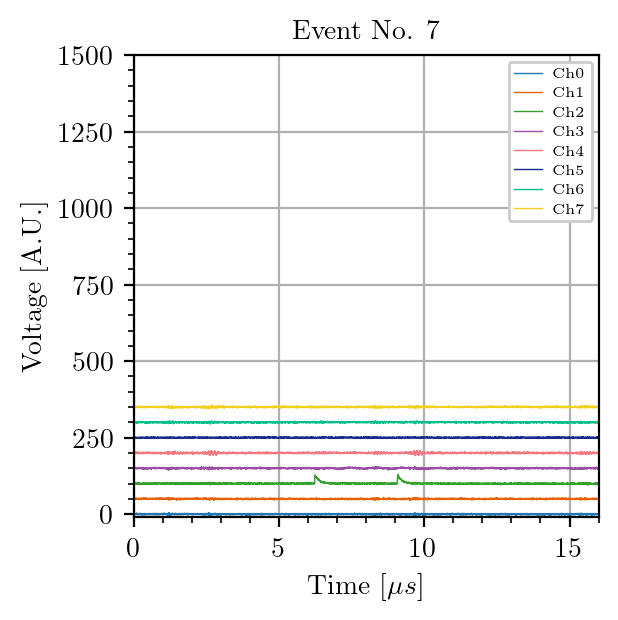

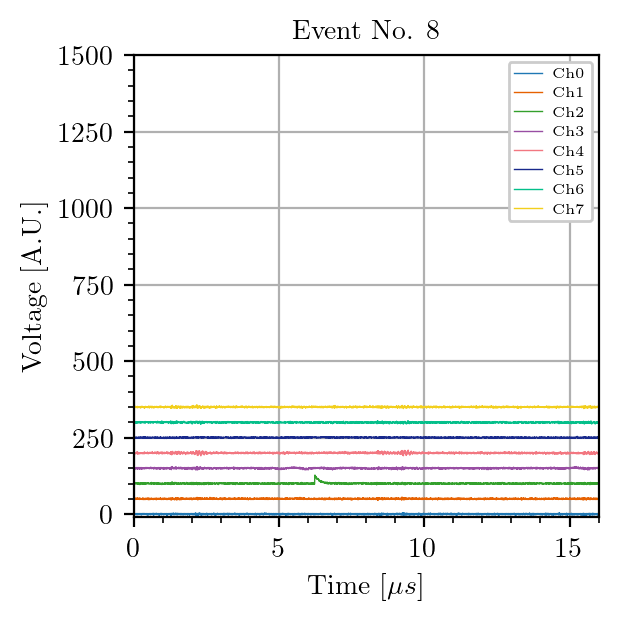

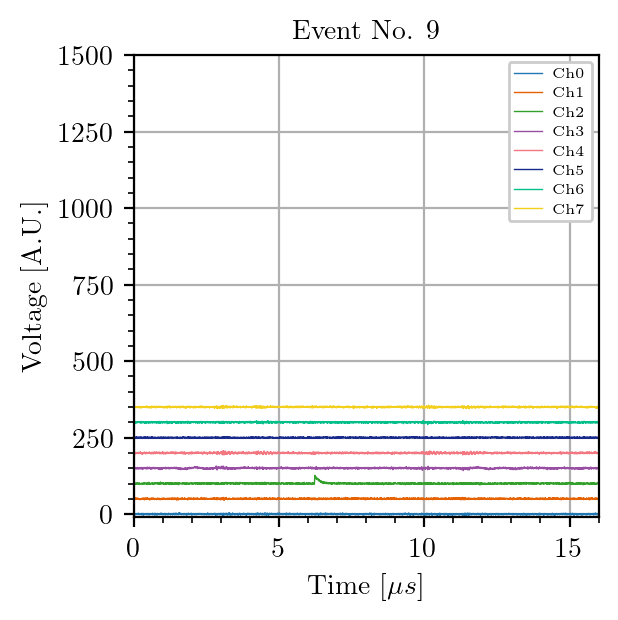

In [2]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/xenon_doping/'
direc = '2024-02-23/2024-02-23_volt_98_light_scintillation_source_co60_xenon_0_cond_gamma/0/'
evid = np.arange(0, 10)
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir, direc), pol=-1, channels=range(8))
wfs = []
for ch in np.arange(8):
    wfs.append(dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)[0])
wfs = np.array(wfs)
print(wfs.shape)
for i in range(wfs.shape[1]):
    plt.figure(i, figsize=(3, 3))
    for ch in range(wfs.shape[0]):
        plt.plot(dset.ch[ch].time, wfs[ch,i]+ch*50, label=f'Ch{ch}', linewidth=0.5)
    plt.legend(loc='upper right', fontsize=5)
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-10, 1500)
    plt.title(f'Event No. {evid[i]}')

## List pre-processed h5 files

In [122]:
path = "/scratch/gpfs/as111/results/"
date = '2024-02-23'
files = [[],[],[],[]] # Co-60, Na-22, Ba-133, Eu-152
files[0].extend(glob(f"{path}{date}/*source_co60*scintillation_pulse_liq6.h5"))
files[1].extend(glob(f"{path}{date}/*source_na22*scintillation_pulse_liq6.h5"))
files[2].extend(glob(f"{path}{date}/*source_ba133*scintillation_pulse_liq6.h5"))
files[3].extend(glob(f"{path}{date}/*source_eu152*scintillation_pulse_liq6.h5"))
print(len(files[0]), files[0])
print(len(files[1]), files[1])
print(len(files[2]), files[2])
print(len(files[3]), files[3])

10 ['/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run9_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run2_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run6_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run3_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run7_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run1_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_run8_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-

## Load h5 files

In [123]:
# data folder
data = {}
date_time = {}
channels = np.arange(-1,8) # channel -1 contains total_pe and fprompt
volt = 98
cond = ['Co-60','Na-22','Ba-133','Eu-152']
for i, c in enumerate(cond):
    if len(files[i])>0:
        data[c] = {}
        for ch in channels:
            data[c][ch] = []
            for f in files[i]:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[c][ch].append(df)
                df = None
            data[c][ch] = pd.concat(data[c][ch]).sort_index()
            if ch!=-1:
                data[c][ch].rename(columns=lambda x: x+f'_{ch}',inplace=True)
        data[c] = pd.concat(list(data[c].values()),axis=1)
    print(f'{data[c].shape[0]} {c} events')
# print(f'{data[cond[1]].shape[0]} background events')
print('columns: ', list(data[cond[0]].columns))

503564 Co-60 events
502997 Na-22 events
503143 Ba-133 events
503165 Eu-152 events
columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'baseline_mean_6', 'baseline_rm

## Read calibration file

In [124]:
calib = pd.read_hdf('data/calibration_liq6_2023-12-13.h5', key=f'{volt}V')
calib

,channel,A1min,A1max,DiCT,DiCT_err,Qavg,Qavg_err,Qpeak,Qpeak_err,Qap,Qap_err,bsl_rms,fano,max_amp
0,0,182.50,614.75,0.062552,0.002565,1365.207392,2.056569,1312.638376,4.241427,0.037543,0.003476,2.0,1.103519,1490
1,1,150.00,507.50,0.078832,0.002711,1083.812145,1.634559,1060.960322,1.525312,0.019841,0.001961,2.0,1.098699,1490
2,2,166.25,517.25,0.038044,0.005497,1074.883609,1.725839,1054.027538,1.298818,0.019034,0.001985,2.0,1.061482,1490
3,3,172.75,595.25,0.063979,0.002884,1347.247295,2.212291,1293.013336,2.911347,0.039260,0.002718,2.0,1.107941,1490
4,4,137.00,491.25,0.037938,0.004298,1089.928296,2.027596,1067.706305,2.465637,0.020023,0.002912,2.0,1.062774,1440
5,5,179.25,605.00,0.064871,0.002205,1340.736508,1.602492,1292.117703,1.517313,0.035186,0.001626,2.0,1.105501,1440
6,6,179.25,595.25,0.061345,0.001571,1348.687297,1.487120,1300.211418,1.903937,0.034996,0.001785,2.0,1.102644,1440
7,7,159.75,523.75,0.041940,0.001757,1085.203042,1.247101,1063.491476,0.622167,0.019559,0.001261,2.0,1.064474,1440


In [125]:
convert_pe = calib['Qavg']/(1-calib['DiCT'])
convert_pe

0    1456.301601
1    1176.563157
2    1117.393326
3    1439.334154
4    1132.908119
5    1433.744368
6    1436.830308
7    1132.708548
dtype: float64

## Compute PEs of top and bottom SiPMs

In [126]:
pe_ch = {}
for c in cond:
    pe_ch[c] = data[c][[f'integral_5p00us_{ch}' for ch in range(8)]]
    pe_ch[c].columns = np.arange(8)
    pe_ch[c] = pe_ch[c]/convert_pe
    data[c]['fs_pe'], data[c]['nofs_pe'] = pe_ch[c].iloc[:,[0,3,5,6]].sum(axis=1), pe_ch[c].iloc[:,[1,2,4,7]].sum(axis=1)
    pe_ch[c] = None

## Baseline cut
Same baseline cut as calibration data (baseline std $<1.8$ ADC units). Cut fraction higher.

In [127]:
# Initialize container
baseline = {}
for c in cond:
    baseline[c] = {}
    for ch in channels:
        baseline[c][ch] = {}

In [128]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in cond:
    for ch in channels[1:]:
        baseline[c][ch]['rms_counts'], baseline[c][ch]['rms_bins'] = np.histogram(data[c][f'baseline_rms_{ch}'], bins=nbins, range=(range_min, range_max))

In [129]:
# Produce baseline mean histograms
nbins = 500
range_min = 3800
range_max = 4000
# rms_threshold = {cond[0]:[1.8]*8,cond[1]:[1.8]*8}
rms_threshold = {'Co-60':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Na-22':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Ba-133':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Eu-152':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0]}
for c in cond:
    for ch in channels[1:]:
        data[c][f'bsl_filt_{ch}'] = data[c][f'baseline_rms_{ch}']<rms_threshold[c][ch]
        baseline[c][ch]['mean_counts'], baseline[c][ch]['mean_bins'] = np.histogram(
            data[c][f'baseline_mean_{ch}'], 
            bins=nbins, range=(range_min, range_max)
        )
        baseline[c][ch]['mean_counts_filt'], baseline[c][ch]['mean_bins_filt'] = np.histogram(
            data[c].loc[data[c][f'bsl_filt_{ch}'],f'baseline_mean_{ch}'], # cut on baseline rms
            bins=nbins, range=(range_min, range_max)
        )

In [130]:
# Print container keys
print('baseline keys: ', list(
    baseline[cond[0]][0].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'mean_counts', 'mean_bins', 'mean_counts_filt', 'mean_bins_filt']


Text(0.07, 0.5, 'Count')

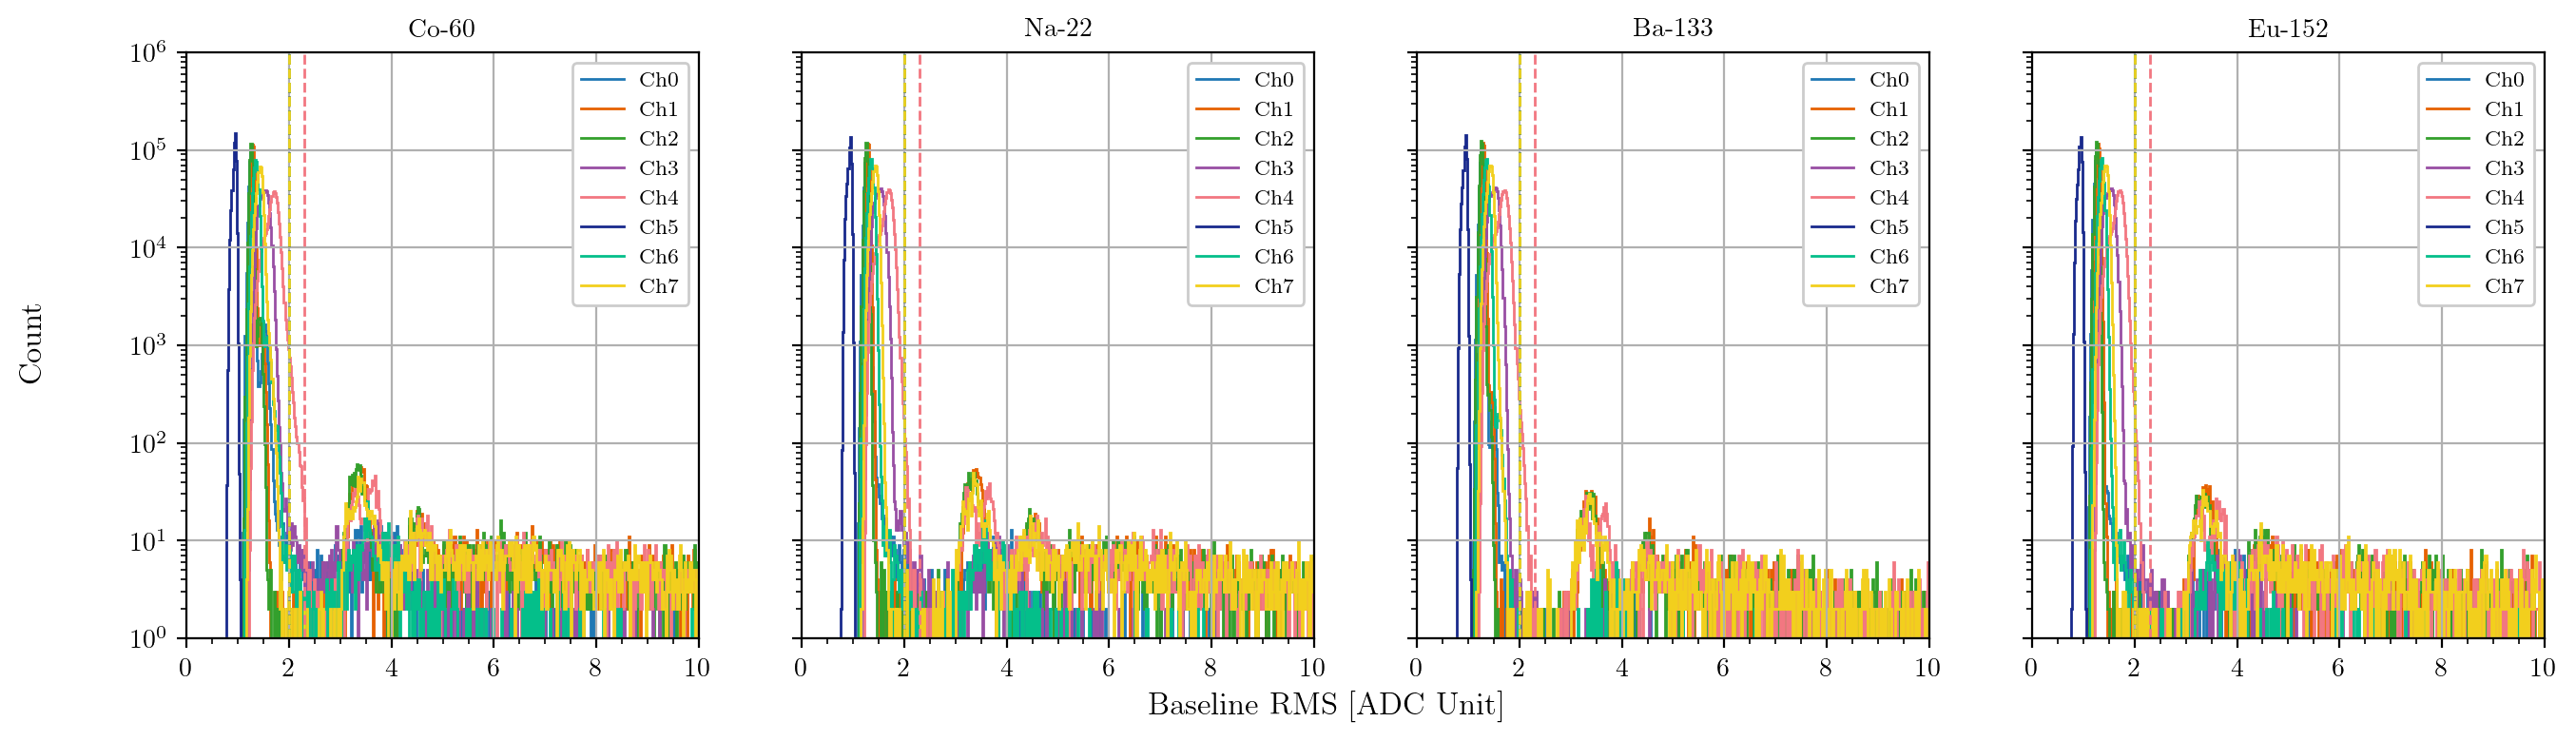

In [131]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(16, 4)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['rms_counts'],
            baseline[c][ch]['rms_bins'],
            label=f'Ch{ch}', color=f'C{j}'
        )
        th = rms_threshold[c][ch]
        axs[i].plot([th, th], [1, 1e6], f'C{j}--', linewidth=1)
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

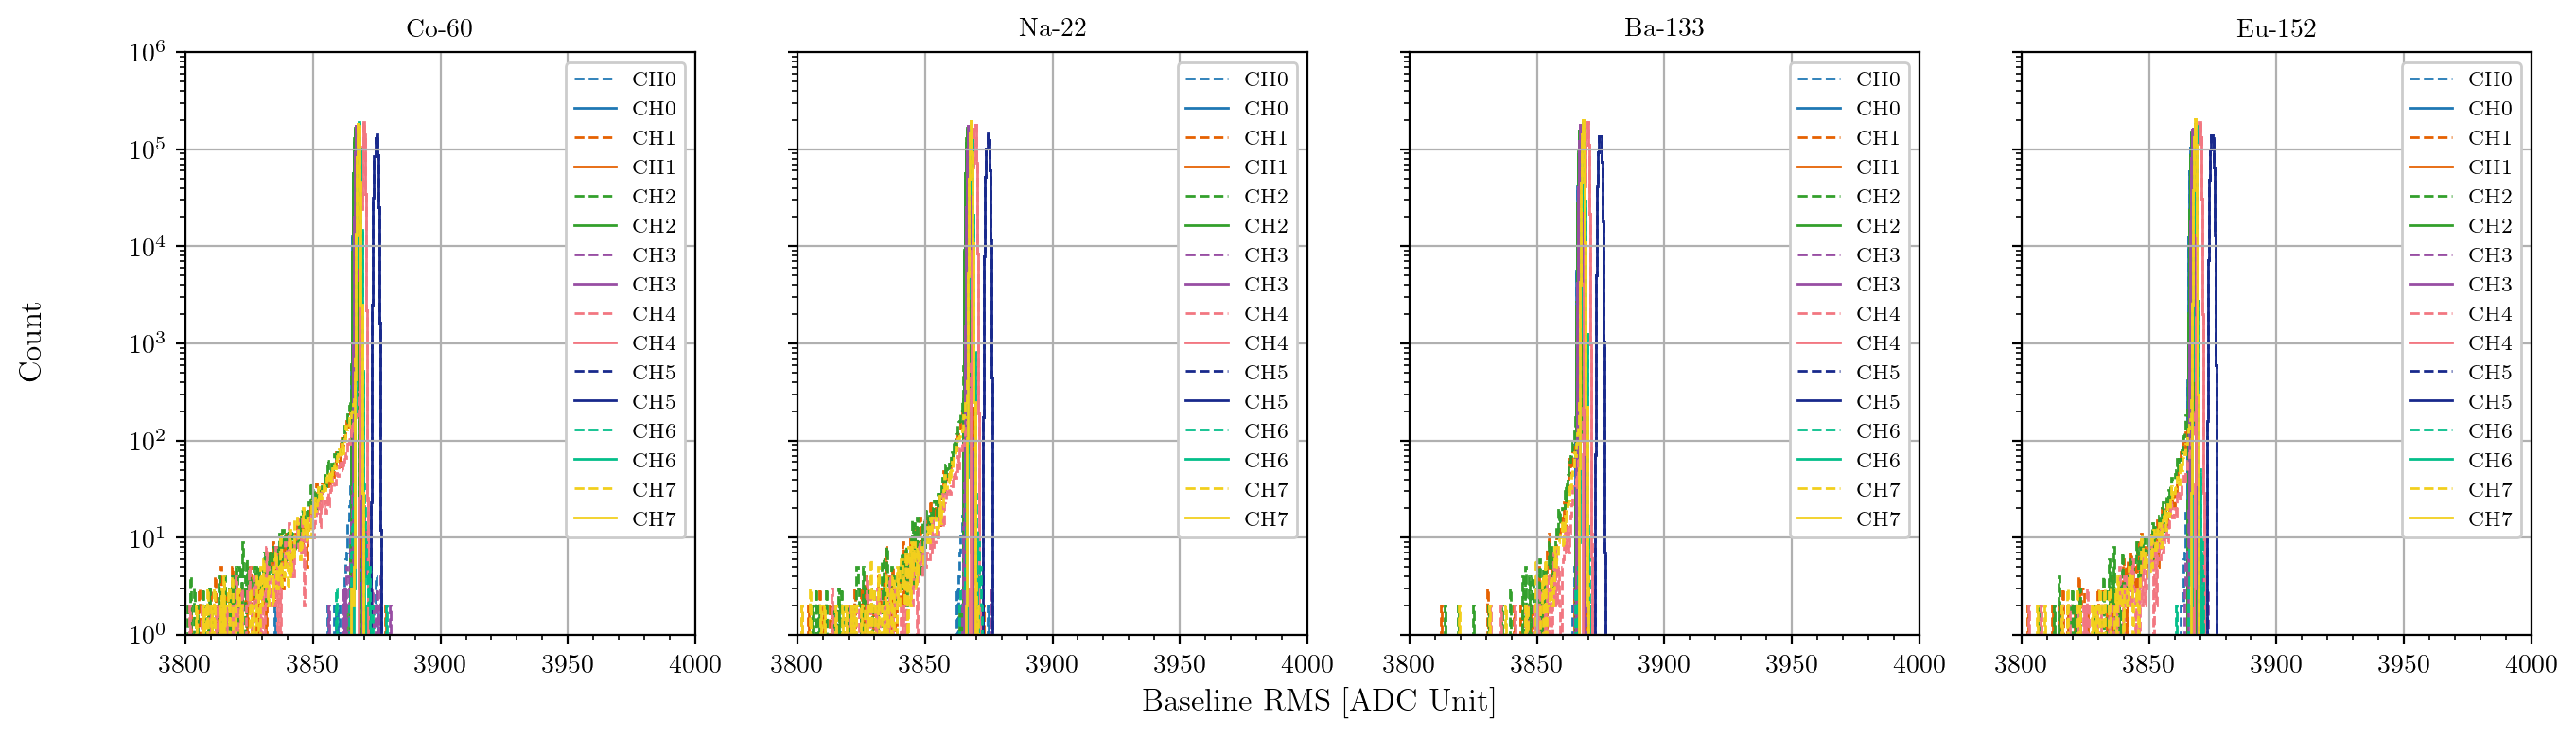

In [132]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(16, 4)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['mean_counts'],
            baseline[c][ch]['mean_bins'],
            label=f'CH{ch}', color=f'C{j}', linestyle='--'
        )
        axs[i].stairs(
            baseline[c][ch]['mean_counts_filt'],
            baseline[c][ch]['mean_bins_filt'],
            label=f'CH{ch}', color=f'C{j}'
        )
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0)
fig.supylabel('Count', x=0.07)

Plots for Eu-152 ch4


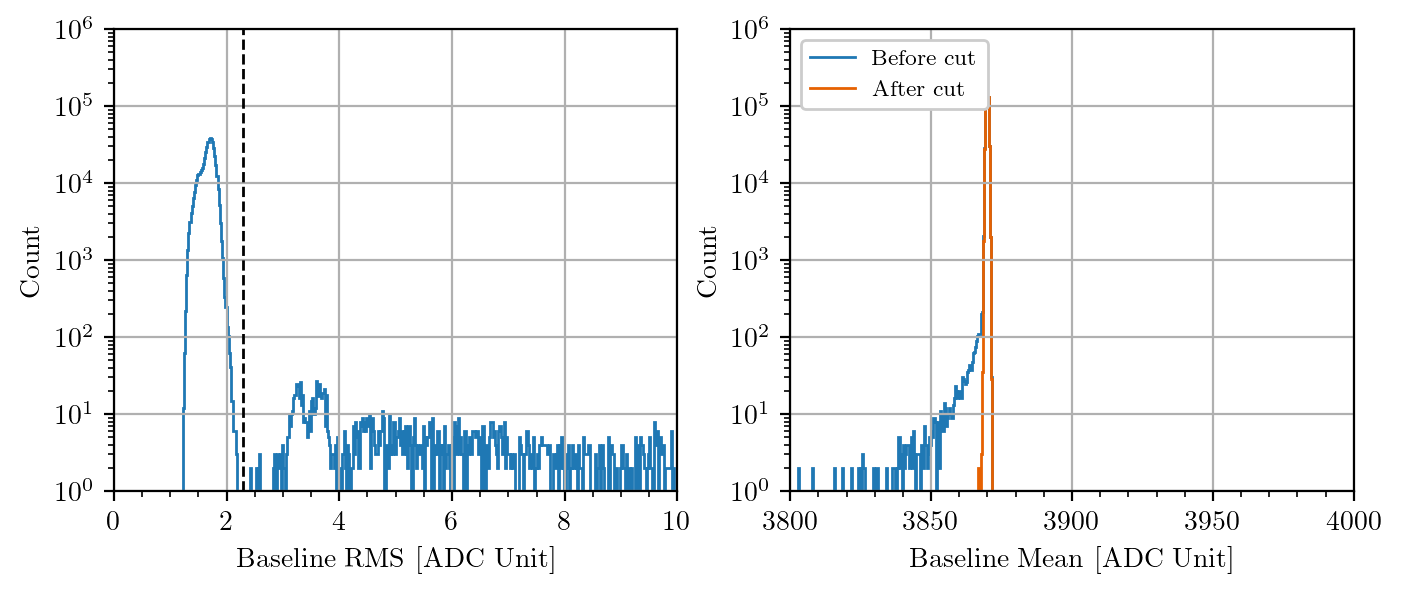

In [133]:
# Make plots for selected dataset
ch = 4
c = 'Eu-152'
print(f'Plots for {c} ch{ch}')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(baseline[c][ch]['rms_counts'],
              baseline[c][ch]['rms_bins'])
th = rms_threshold[c][ch]
axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e6)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(baseline[c][ch]['mean_counts'],
              baseline[c][ch]['mean_bins'],
              label='Before cut')
axs[1].stairs(baseline[c][ch]['mean_counts_filt'],
              baseline[c][ch]['mean_bins_filt'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e6)
axs[1].set_xlim(3800, 4000)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Saturated peaks
Find maximum amplitude and remove those events reaching maximum amplitude.

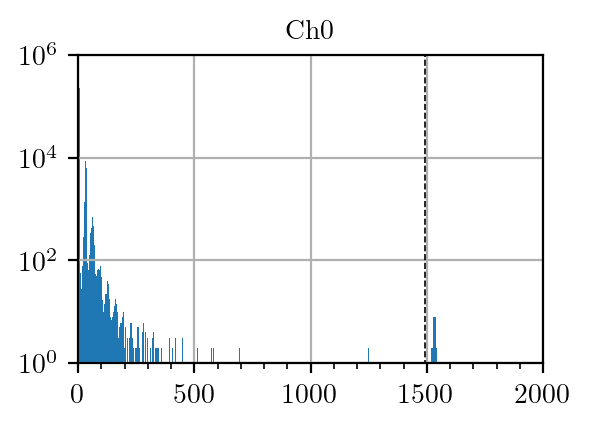

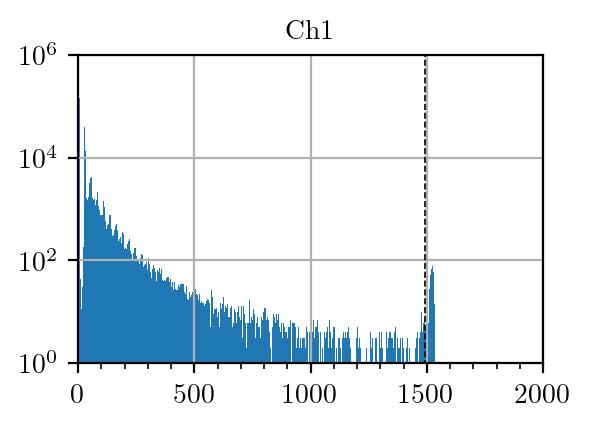

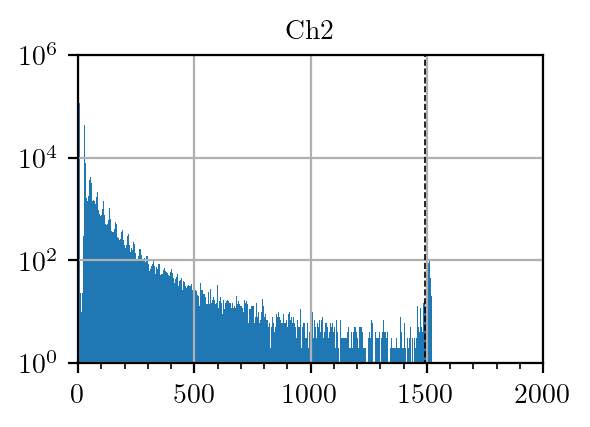

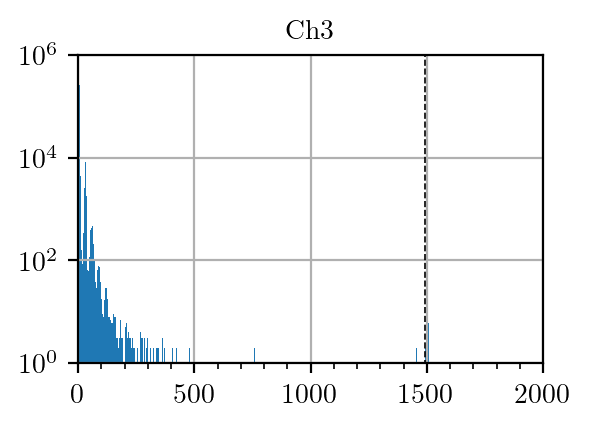

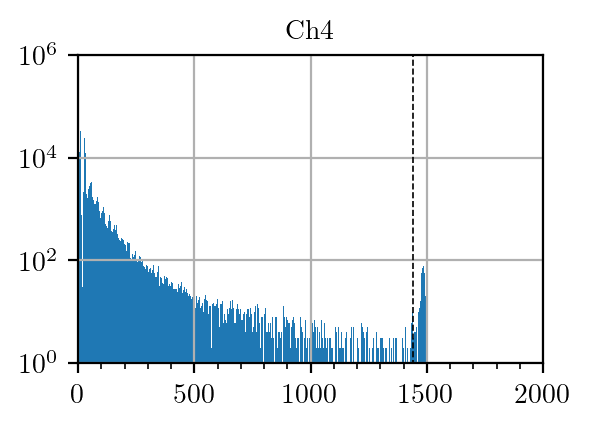

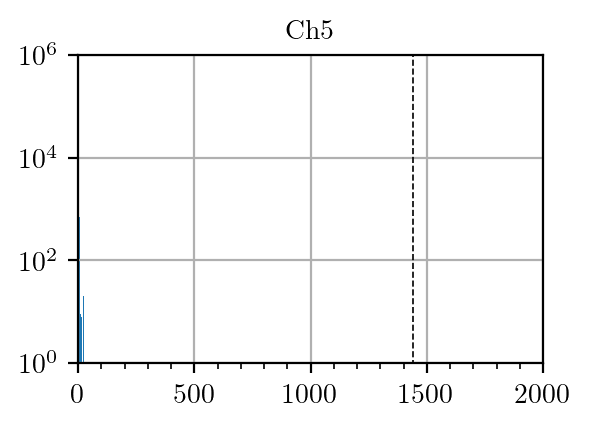

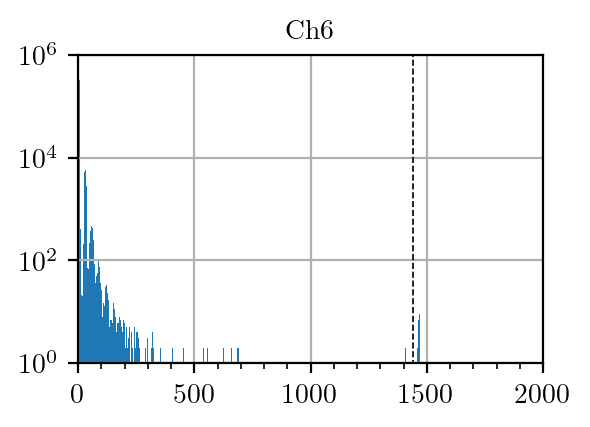

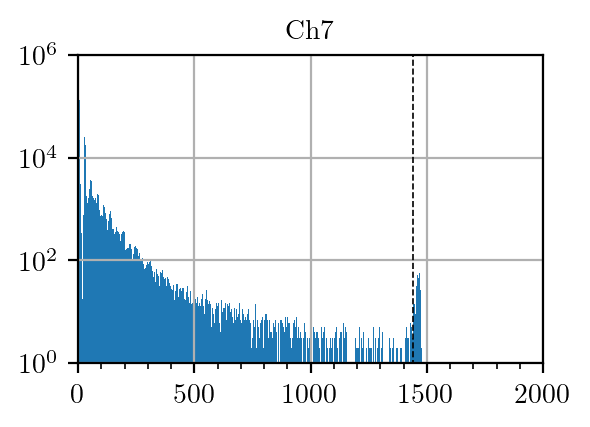

In [134]:
amp_sat = [1490]*4+[1440]*4
for ch in channels[1:]:
    plt.figure(ch,figsize=(3,2))
    plt.hist(data[cond[0]][f'amplitude_{ch}'],bins=np.linspace(0,1600,1000))
    plt.plot([amp_sat[ch]]*2,[0,1e6],'k--',linewidth=0.6)
    plt.title(f'Ch{ch}')
    plt.yscale('log')
    plt.grid()
    plt.minorticks_on()
    plt.ylim(0,1e6)
for c in cond:
    for ch in channels[1:]:
        data[c][f'sat_filt_{ch}'] = data[c][f'amplitude_{ch}']<amp_sat[ch]

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.3~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely pile-ups.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [135]:
# Initialize container
fprompt = {}
positions = ['all','fs','nofs']
for c in cond:
    fprompt[c] = {}
    for p in positions:
        fprompt[c][p] = {}

In [136]:
# Produce fprompt 2D histograms
nbinsx = 500
range_minx = -10
range_maxx = 600
nbinsy = 500
range_miny = 0
range_maxy = 1

for c in cond:
    data[c]['bsl_filt'] = data[c][[f'bsl_filt_{ch}' for ch in range(8)]].all(axis=1)
    data[c]['sat_filt'] = data[c][[f'sat_filt_{ch}' for ch in range(8)]].all(axis=1)
    filt = data[c]['bsl_filt'] & data[c]['sat_filt']
    fprompt[c]['all']['fp_counts'], fprompt[c]['all']['fp_xbins'], fprompt[c]['all']['fp_ybins'] = np.histogram2d(
        data[c]['total_pe'][filt], 
        data[c]['fprompt_0p30us_01234567'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['fs']['fp_counts'], fprompt[c]['fs']['fp_xbins'], fprompt[c]['fs']['fp_ybins'] = np.histogram2d(
        data[c]['fs_pe'][filt], 
        data[c]['fprompt_0p30us_0356'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['nofs']['fp_counts'], fprompt[c]['nofs']['fp_xbins'], fprompt[c]['nofs']['fp_ybins'] = np.histogram2d(
        data[c]['nofs_pe'][filt], 
        data[c]['fprompt_0p30us_1247'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    for p in positions:
        fprompt[c][p]['fp_counts'] = fprompt[c][p]['fp_counts'].T
        fprompt[c][p]['fp_xbins'], fprompt[c][p]['fp_ybins'] = np.meshgrid(
            fprompt[c][p]['fp_xbins'], fprompt[c][p]['fp_ybins']
        )
        fprompt[c][p]['fp_threshold'] = 0.1
    data[c]['fp_filt'] = data[c]['fprompt_0p30us_01234567']>fprompt[c]['all']['fp_threshold']
    data[c]['all_filt'] = data[c][['bsl_filt','sat_filt','fp_filt']].all(axis=1)

Text(0.07, 0.5, '$F_{\\rm 0.3\\mu s}$')

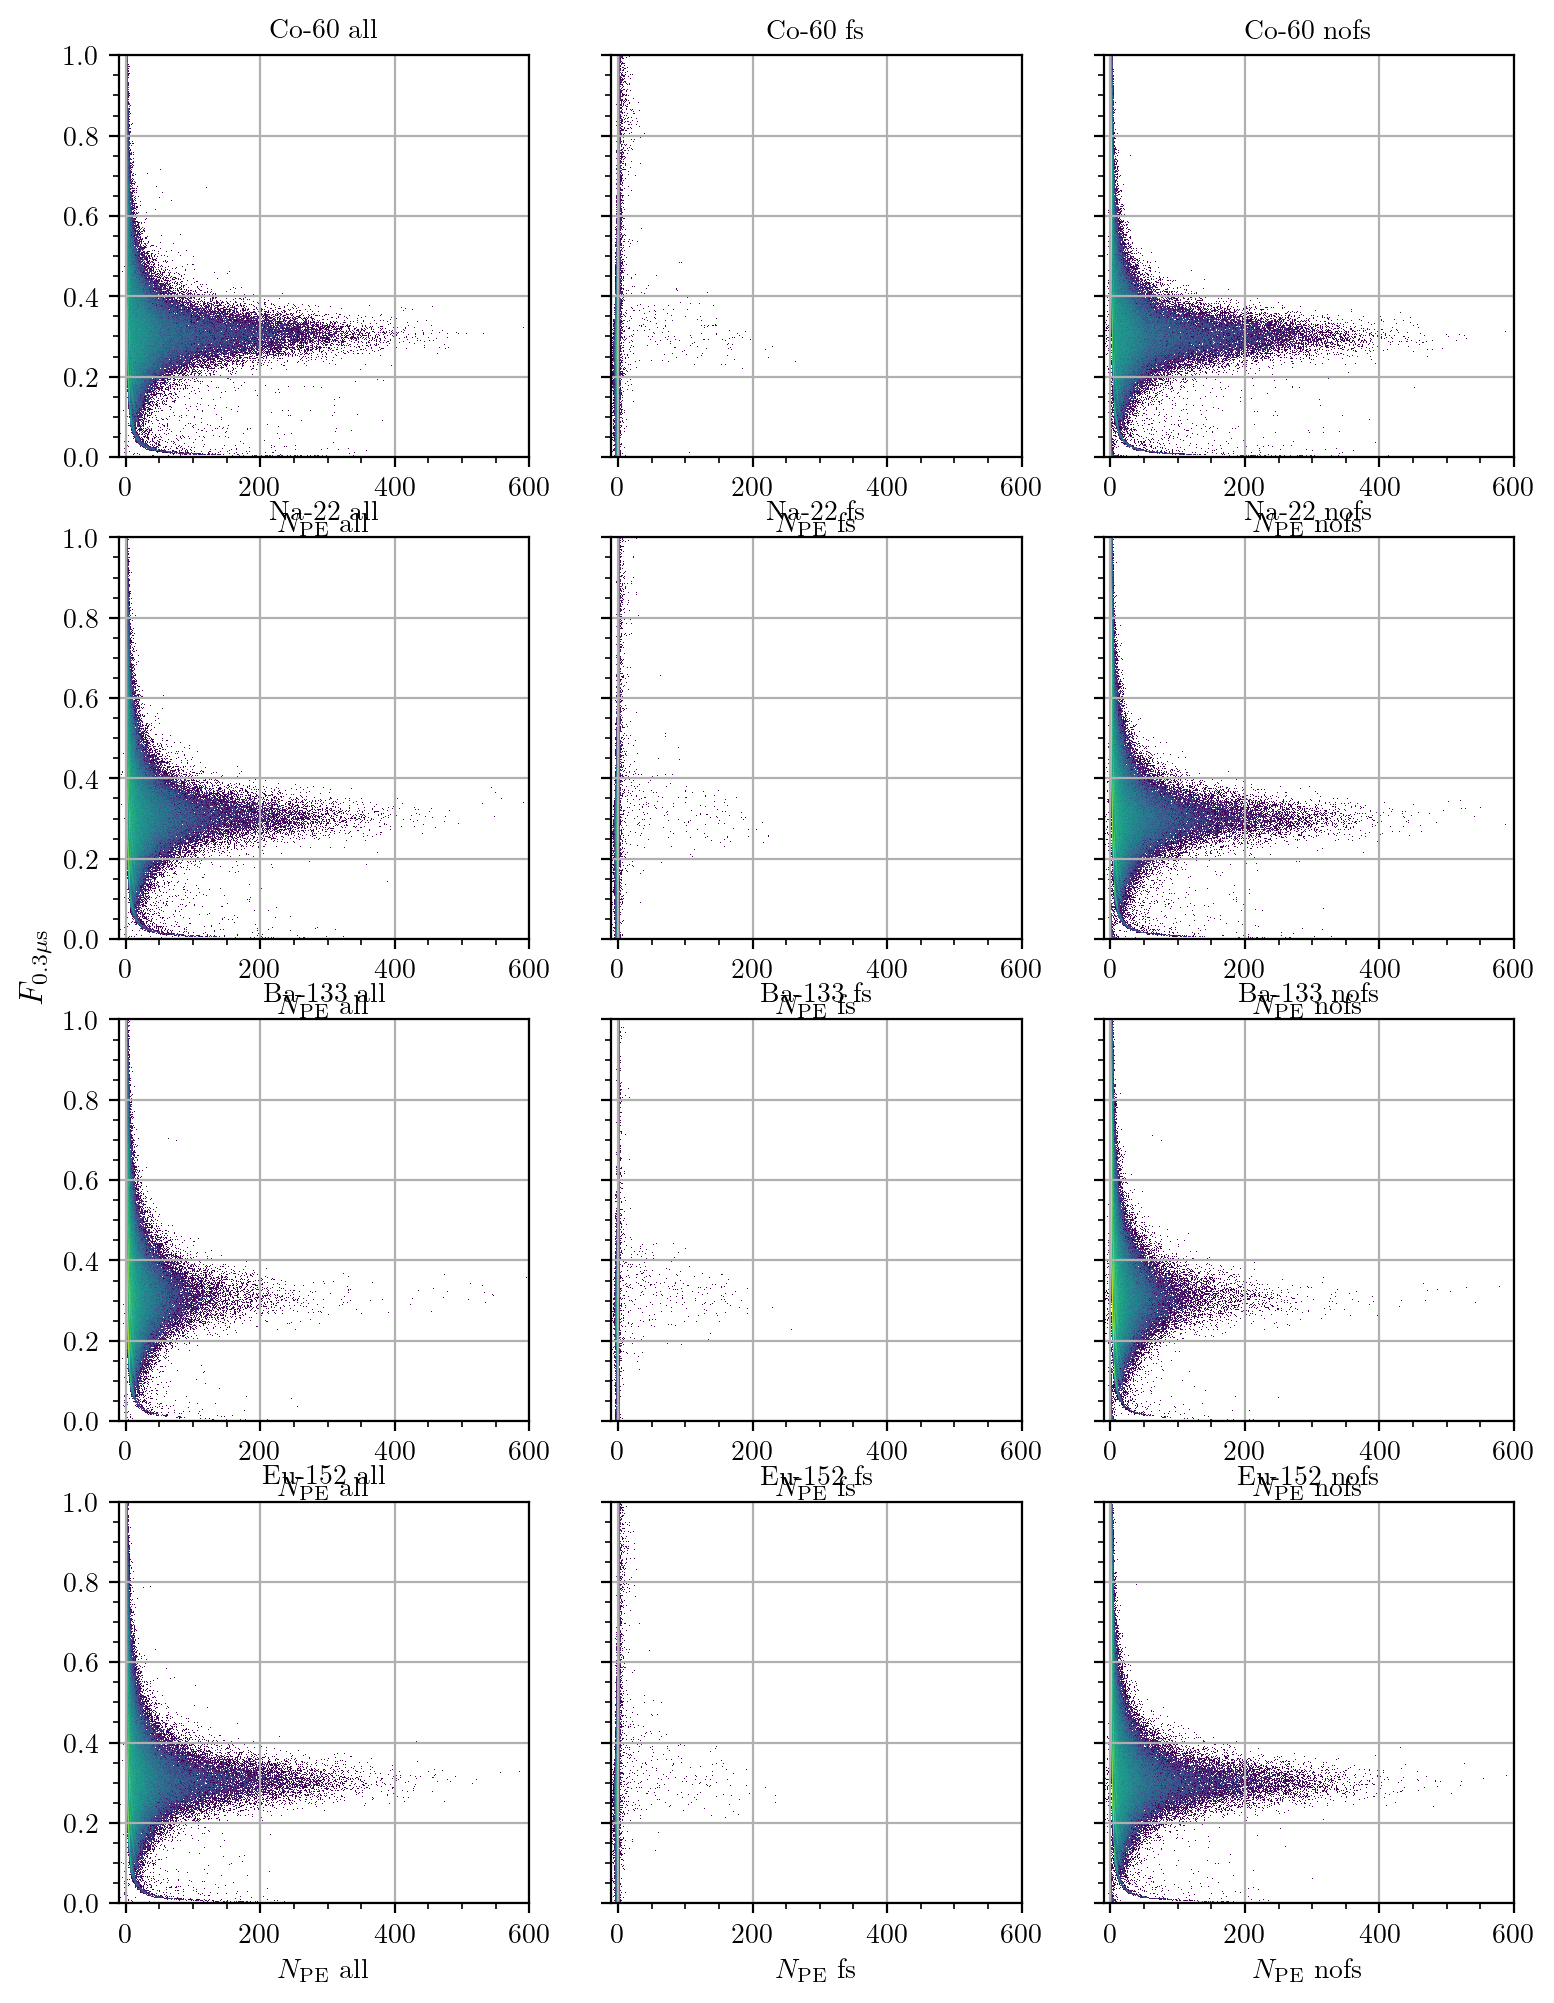

In [137]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(4, 3, sharex=False, sharey=True)
fig.set_size_inches(9, 12)
for i, c in enumerate(cond):
    for j, p, in enumerate(positions):
        axs[i,j].pcolormesh(
            fprompt[c][p]['fp_xbins'],
            fprompt[c][p]['fp_ybins'],
            np.log10(fprompt[c][p]['fp_counts'])
        )
        th = fprompt[c][p]['fp_threshold']
        axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{c} {p}')
        axs[i,j].set_xlabel(r'$N_{\rm PE}$ ' + p)
fig.supylabel(r'$F_{\rm 0.3\mu s}$', x=0.07)

In [138]:
# Print container keys
print('fprompt keys: ', list(
    fprompt[cond[0]].keys()))

fprompt keys:  ['all', 'fs', 'nofs']


## Event ID selection

In [139]:
sel = (data['Co-60']['total_pe']>500) & (data['Co-60']['total_pe']<600) & data['Co-60']['all_filt']
ev_id = data['Co-60'][sel].index[:10].get_level_values(1).to_numpy()
print(ev_id)
data['Co-60'][sel]

[ 5955 41198 35293 38005 48902 20548]


start_datetime  end_datetime  duration_seconds  nch  nch_fs  \
run event                                                                
0   5955              NaN           NaN               NaN    5       1   
1   41198             NaN           NaN               NaN    4       0   
6   35293             NaN           NaN               NaN    6       2   
    38005             NaN           NaN               NaN    6       2   
8   48902             NaN           NaN               NaN    4       0   
9   20548             NaN           NaN               NaN    6       2   

           nch_nofs    total_pe  fprompt_0p30us_01234567  fprompt_0p30us_0356  \
run event                                                                       
0   5955          4  503.099835                 0.291627             0.161446   
1   41198         4  506.658077                 0.307621             0.237420   
6   35293         4  591.177080                 0.323157             1.608355   
    38005         4  550.629256                 0.302396             1.296640   
8   48902         4  517.258170                 0.310777            -0.107315   
9   20548         4  531.932940                 0.306185             3.304627   

           fprompt_0p30us_1247  ...  sat_filt_2  sat_filt_3  sat_filt_4  \
run event                       ...                                       
0   5955              0.288065  ...        True        True        True   
1   41198             0.305600  ...        True        True        True   
6   35293             0.313138  ...        True        True        True   
    38005             0.282252  ...        True        True        True   
8   48902             0.302195  ...        True        True        True   
9   20548             0.294655  ...        True        True        True   

           sat_filt_5  sat_filt_6  sat_filt_7  bsl_filt  sat_filt  fp_filt  \
run event                                                                    
0   5955         True        True        True      True      True     True   
1   41198        True        True        True      True      True     True   
6   35293        True        True        True      True      True     True   
    38005        True        True        True      True      True     True   
8   48902        True        True        True      True      True     True   
9   20548        True        True        True      True      True     True   

           all_filt  
run event            
0   5955       True  
1   41198      True  
6   35293      True  
    38005      True  
8   48902      True  
9   20548      True  

[6 rows x 88 columns]

## Top-Bottom 2D Distribution
Use the boxed region to determine background scaling factor.

In [140]:
nbinsx = 500
range_minx = -50
range_maxx = 500
nbinsy = 500
range_miny = -50
range_maxy = 500

top_bot_pe = {}
for c in cond:
    top_bot_pe[c] = {}
    top_bot_pe[c]['counts'], top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.histogram2d(
        data[c]['nofs_pe'][data[c]['all_filt']], 
        data[c]['fs_pe'][data[c]['all_filt']], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    top_bot_pe[c]['counts'] = top_bot_pe[c]['counts'].T
    top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.meshgrid(
        top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins']
    )

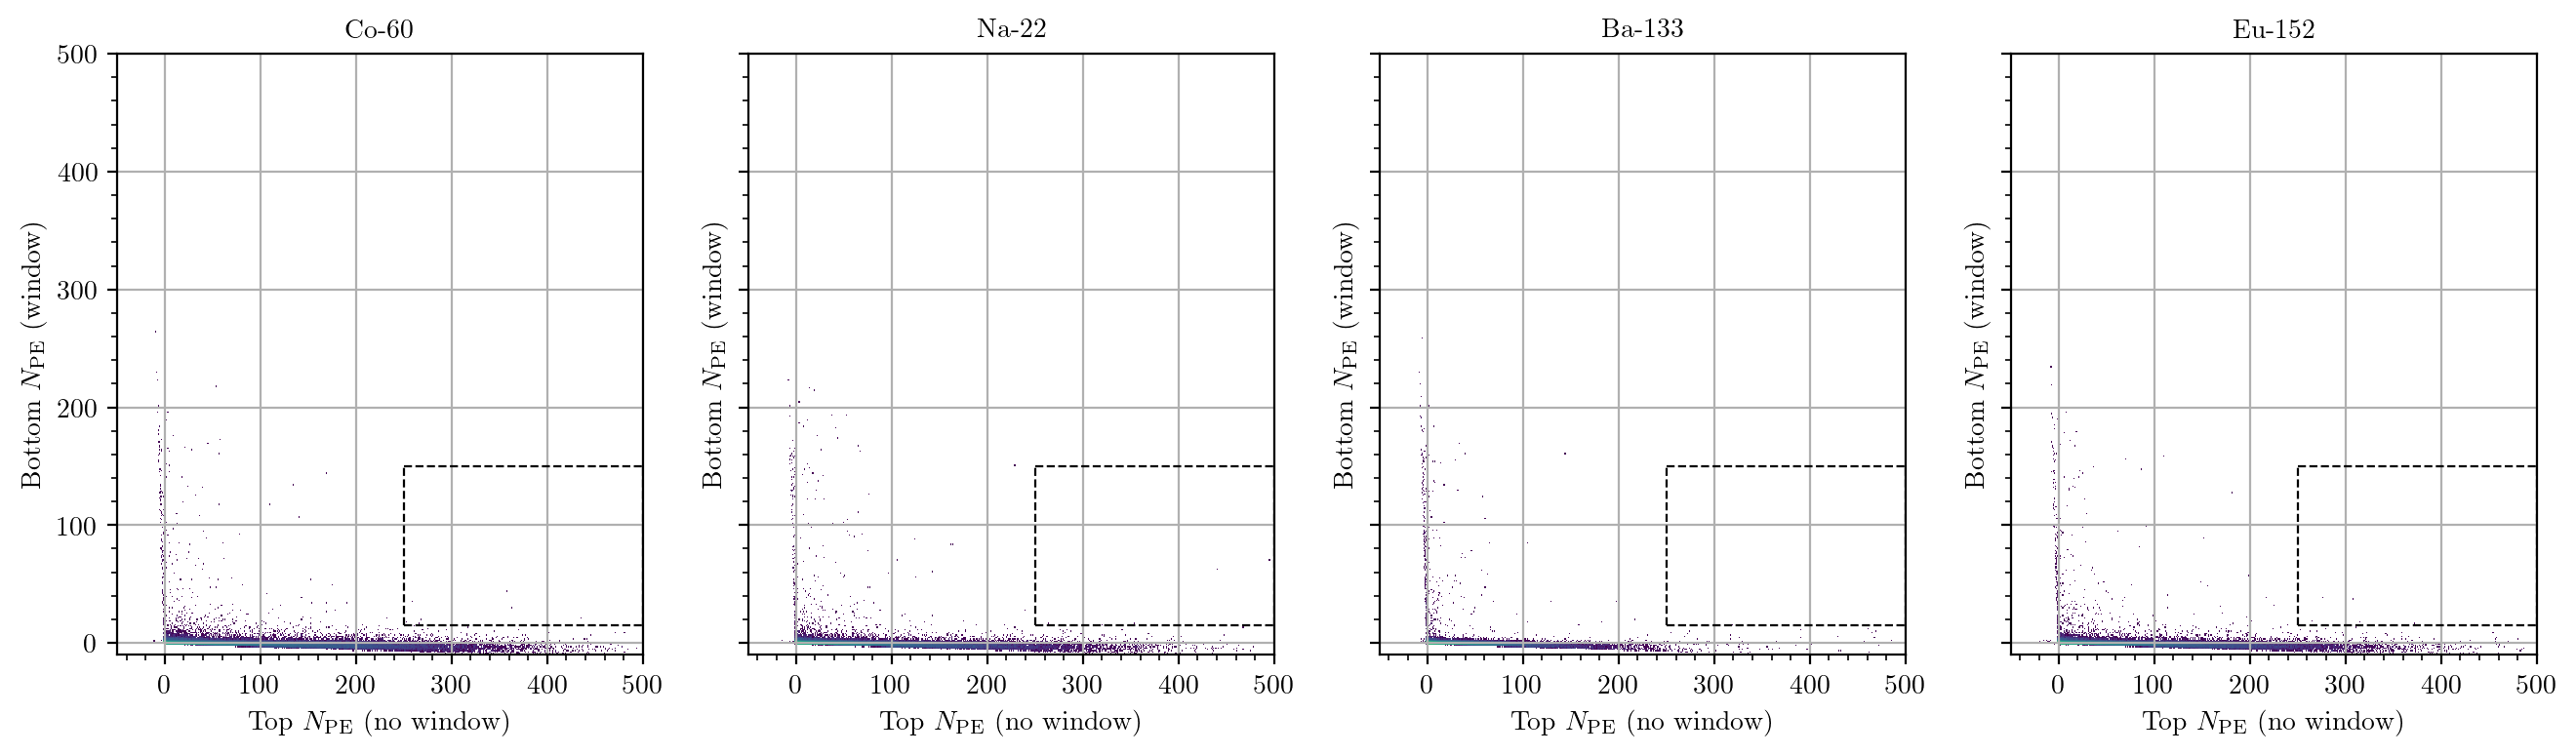

In [141]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(16, 4)
x1, y1, x2, y2 = 250, 15, 500, 150
for i, c in enumerate(cond):
    axs[i].pcolormesh(
        top_bot_pe[c]['xbins'],
        top_bot_pe[c]['ybins'],
        np.log10(top_bot_pe[c]['counts'])
    )
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
    axs[i].set_xlim(-50, 500)
    axs[i].set_ylim(-10, 500)
    axs[i].set_xlabel(r'Top $N_{\rm PE}$ (no window)')
    axs[i].set_ylabel(r'Bottom $N_{\rm PE}$ (window)')
    axs[i].plot([x1,x1], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x2,x2], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y1,y1], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y2,y2], 'k--', linewidth=0.8)

mask_x, mask_y = (top_bot_pe[c]['xbins'][0,1:]<x2)&(top_bot_pe[c]['xbins'][0,1:]>x1), (top_bot_pe[c]['ybins'][1:,0]<y2)&(top_bot_pe[c]['ybins'][1:,0]>y1)
# bkg_scale = np.sum(top_bot_pe[cond[0]]['counts'][mask_y][:,mask_x])/np.sum(top_bot_pe[cond[1]]['counts'][mask_y][:,mask_x])
# print(f'Backgrounds to be scaled by {bkg_scale}')

## Channel-by-channel comparison

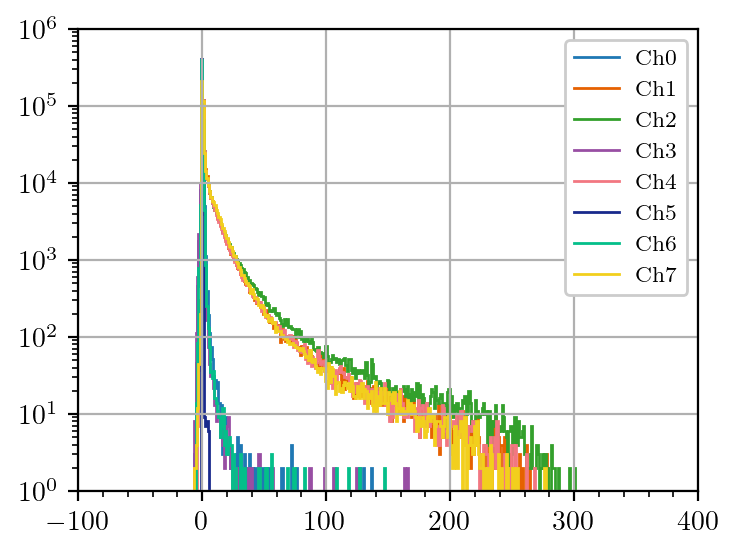

In [142]:
for i in range(8):
    hist,bins = np.histogram(data['Co-60'][data['Co-60']['all_filt']][f'integral_5p00us_{i}']/convert_pe[i],bins=np.linspace(-30,400,400));
    plt.stairs(hist,bins,label=f'Ch{i}')
plt.yscale('log')
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper right')

## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm avg}/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).

In [143]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [144]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data[c]['nofs_pe'][data[c]['all_filt']] if w=='no' else data[c]['fs_pe'][data[c]['all_filt']], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])
        # if c=='Backgrounds':
        #     spectra[c][w]['counts'] = spectra[c][w]['counts']*bkg_scale
        #     spectra[c][w]['errs'] = spectra[c][w]['errs']*bkg_scale

## Cut selection effects

(-50.0, 1000.0)

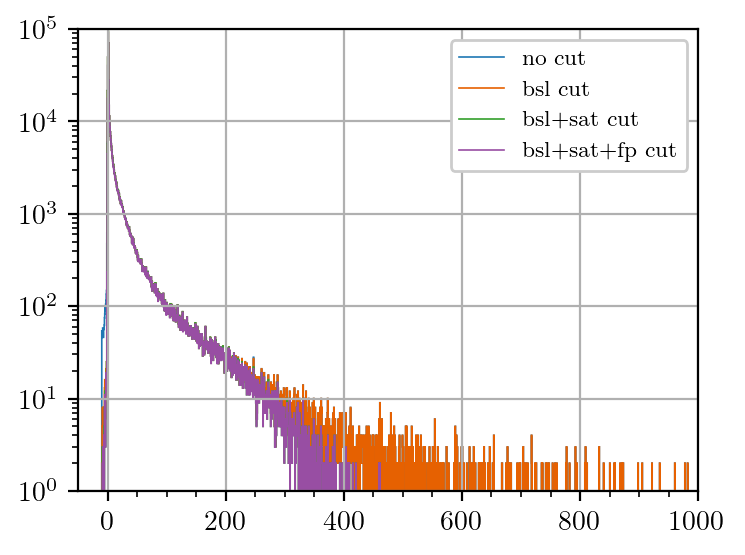

In [145]:
c = 'Eu-152'
filt1 = data[c]['bsl_filt']
filt2 = filt1 & data[c]['sat_filt']
filt3 = filt2 & data[c]['fp_filt']
hist0 = np.histogram(data[c]['nofs_pe'],bins=4000,range=(-10,2000))
hist1 = np.histogram(data[c]['nofs_pe'][filt1],bins=4000,range=(-10,2000))
hist2 = np.histogram(data[c]['nofs_pe'][filt2],bins=4000,range=(-10,2000))
hist3 = np.histogram(data[c]['nofs_pe'][filt3],bins=4000,range=(-10,2000))
plt.stairs(*hist0,label='no cut',linewidth=0.6)
plt.stairs(*hist1,label='bsl cut',linewidth=0.6)
plt.stairs(*hist2,label='bsl+sat cut',linewidth=0.6)
plt.stairs(*hist3,label='bsl+sat+fp cut',linewidth=0.6)
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid()
plt.minorticks_on()
plt.xlim(-50,1000)

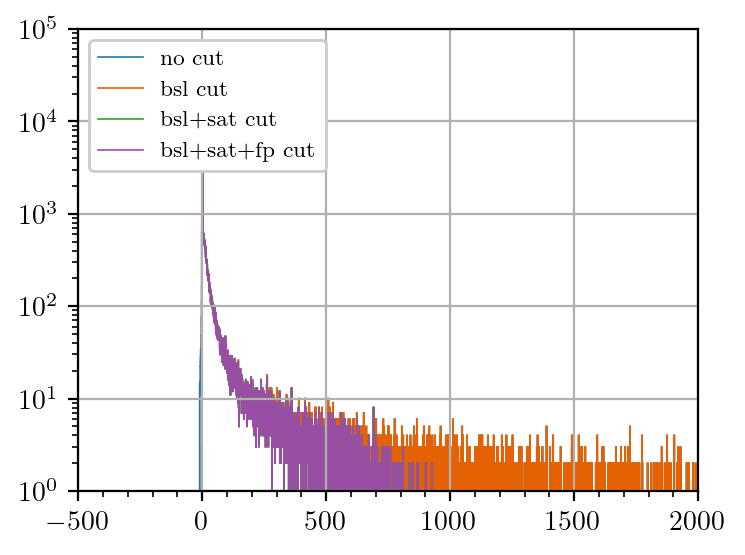

In [41]:
# c = cond[1]
# filt1 = data[c]['bsl_filt']
# filt2 = filt1 & data[c]['sat_filt']
# filt3 = filt2 & data[c]['fp_filt']
# hist0 = np.histogram(data[c]['top_pe'],bins=4000,range=(-10,2000))
# hist1 = np.histogram(data[c]['top_pe'][filt1],bins=4000,range=(-10,2000))
# hist2 = np.histogram(data[c]['top_pe'][filt2],bins=4000,range=(-10,2000))
# hist3 = np.histogram(data[c]['top_pe'][filt3],bins=4000,range=(-10,2000))
# plt.stairs(*hist0,label='no cut',linewidth=0.6)
# plt.stairs(*hist1,label='bsl cut',linewidth=0.6)
# plt.stairs(*hist2,label='bsl+sat cut',linewidth=0.6)
# plt.stairs(*hist3,label='bsl+sat+fp cut',linewidth=0.6)
# plt.yscale('log')
# plt.legend()
# plt.grid()
# plt.minorticks_on()

Text(0.07, 0.5, 'Count')

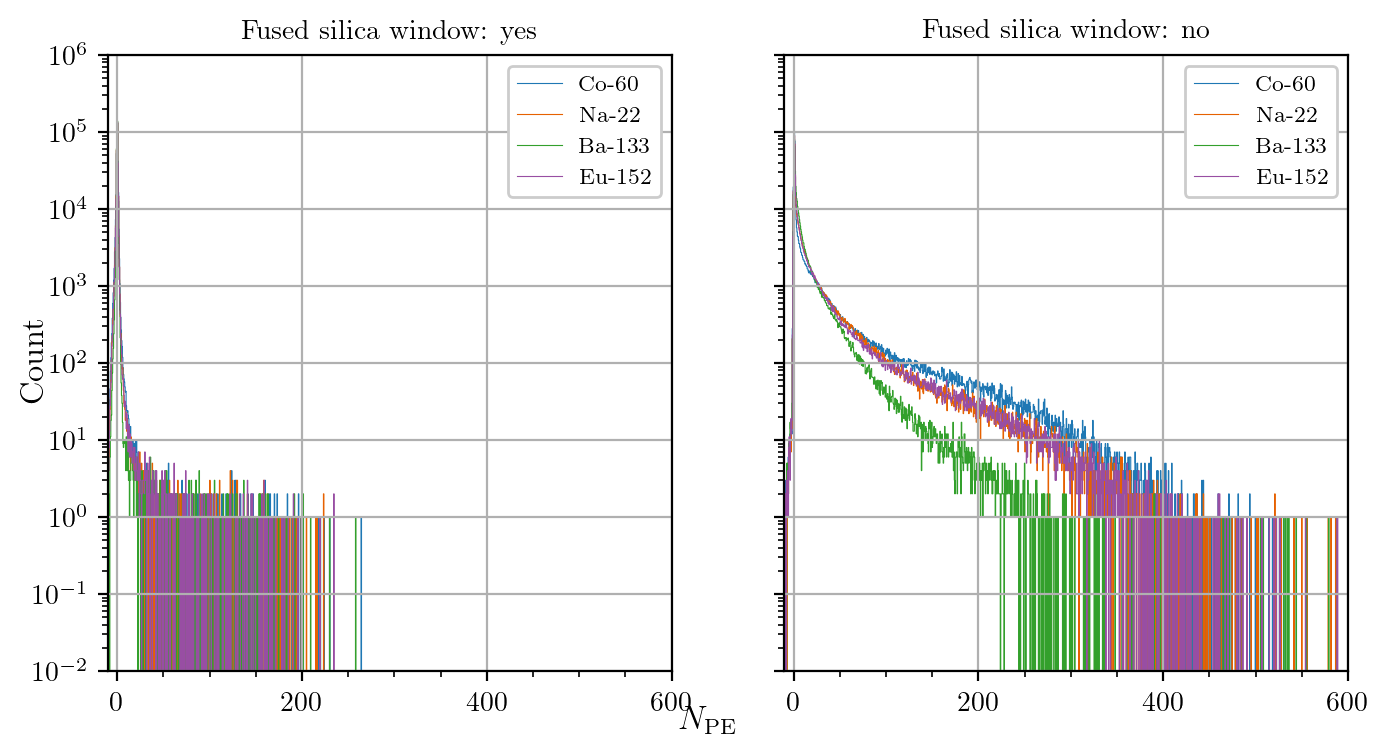

In [146]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(8, 4)
for j, w in enumerate(window):
    for i, c in enumerate(cond):
        axs[j].stairs(
            spectra[c][w]['counts'],
            spectra[c][w]['bins'],
            label=f'{c}', color=f'C{i}', linewidth=0.4
        )
    # axs[j].stairs(spectra['Co-60'][w]['counts']-spectra['Backgrounds'][w]['counts'], 
    #               spectra['Co-60'][w]['bins'], label='Difference', color='C2')
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-2, 1e6)
    axs[j].set_xlim(-10, 600)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Count', x=0.07)

## G4DS simulation (Compton scattering + UV photon transport)

Text(0, 0.5, 'Count')

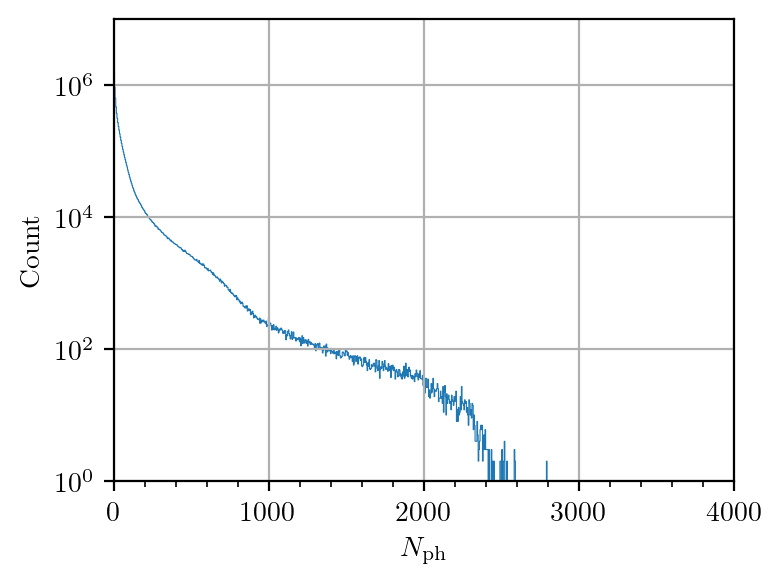

In [90]:
rtf = uproot.open('data/pu_lar_co60_hist.root')
hist_sim_nofs = rtf['nph_nofs_1247'].to_numpy()
plt.stairs(hist_sim_nofs[0],hist_sim_nofs[1],linewidth=0.4)
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$N_{\rm ph}$')
plt.ylabel('Count')

## G4DS simulation (energy deposition only)

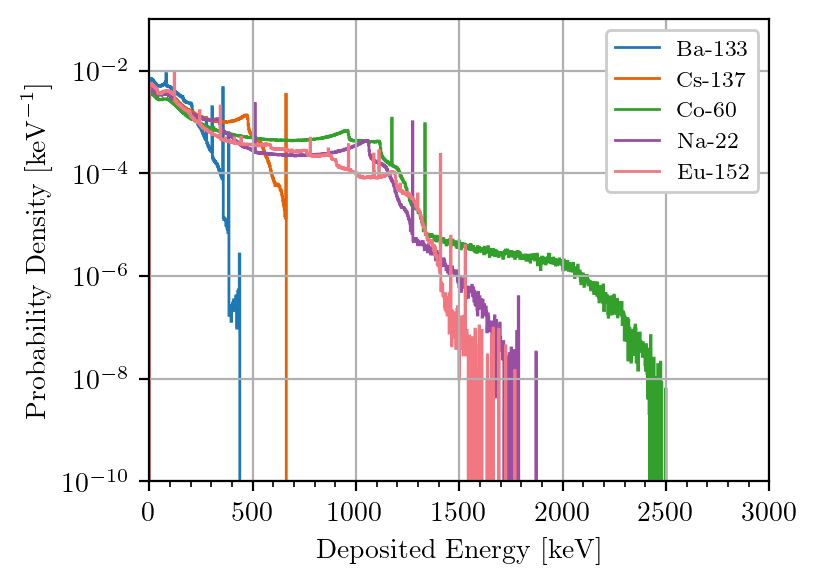

In [91]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root','spectrum_cs137_ene.root','spectrum_co60_ene.root','spectrum_na22_ene.root','spectrum_eu152_ene.root']
gammas = ['Ba-133','Cs-137','Co-60','Na-22','Eu-152']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-10,1e-1)
plt.xlim(0,3000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

## Detector response model
The number of PE follows the distribution
$$N_{\rm PE} \sim \mathcal{N}(\mu=N_{\rm ph}\times\varepsilon_p S_y/S_y^0, \sigma=\sqrt{F\mu + \alpha^2 \mu^2}),$$
where $N_{\rm ph}$ is the number of photons arriving at the SiPMs (from G4DS), $\varepsilon_p$ is the SiPMs' photo-detection efficiency (PDE), $S_y^0$ is the nominal (maximum) LAr scintillation yield $1ph/19.5eV=51.3ph/keV$ (default in G4DS), $S_y$ is the true scintillation yield ($\approx 40ph/keV$ for LAr), $F$ is the Fano factor of the SiPMs due to correlated avalanches, and $\alpha$ is a smearing factor accounting for scintillation directionality.

In [92]:
class DetectorSmearing():
    def __init__(self, pde, fano, hist_in):
        self.hist_in_bin = hist_in[1]
        self.hist_in_width = self.hist_in_bin[1]-self.hist_in_bin[0]
        self.hist_in_count = hist_in[0]/np.sum(hist_in[0])/self.hist_in_width # normalized
        self.fano = fano
        self.pde = pde

    def response_matrix(self, pe_in, pe_out, smear2):
        pe_det = self.pde*pe_in
        return norm.pdf(pe_out, loc=self.pde*pe_in, scale=np.sqrt(self.fano*pe_det + smear2**2*pe_det**2))

    def get_spectrum(self, bins, n, smear2):
        self.hist_out_bin = bins
        bin_cen_in = (self.hist_in_bin[1:]+self.hist_in_bin[:-1])/2
        bin_cen_out = (self.hist_out_bin[1:]+self.hist_out_bin[:-1])/2
        pe_out_mesh, pe_in_mesh = np.meshgrid(bin_cen_out, bin_cen_in)
        self.hist_out_count = self.hist_in_count @ self.response_matrix(pe_in_mesh, pe_out_mesh, smear2)
        return n*self.hist_out_count, self.hist_out_bin
        
    def fit_to_data(self, data, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            n, smear2 = x[0], x[1]
            data_y, data_bin = args[0], args[1]
            bincen = (data_bin[1:] + data_bin[:-1])/2
            ans = (data_y-self.get_spectrum(data_bin, n, smear2)[0])
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (bincen<fit_range[1]) & (bincen>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data,bounds=(0,np.inf))
        return res.x
        

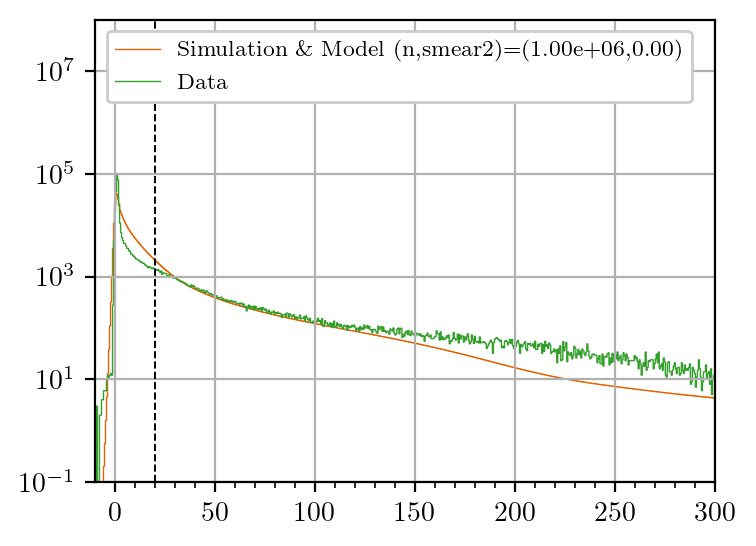

In [121]:
fit_range = (20,400)
ymin, ymax = 1e-1,1e8
smear = DetectorSmearing(pde=0.3*4/5,fano=1.063,hist_in=hist_sim_nofs)
# par = smear.fit_to_data(
#     data=(spectra['Co-60']['no']['counts'],spectra['Co-60']['no']['bins']),
#     sigma=spectra['Co-60']['no']['errs'],
#     x0=[2e6,0.1],
#     fit_range=fit_range
# )
par = [1e6,0.]
plt.stairs(*(smear.get_spectrum(spectra['Co-60']['no']['bins'],*par)), label='Simulation \& Model '+f'(n,smear2)=({par[0]:.2e},{par[1]:.2f})', color='C1', linewidth=0.5)
plt.stairs(spectra['Co-60']['no']['counts'],spectra['Co-60']['no']['bins'], label='Data', color='C2', linewidth=0.5)
plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
plt.yscale('log')
plt.minorticks_on()
plt.grid()
plt.ylim(1e-1,1e8)
plt.xlim(-10,300)
plt.legend()